In [0]:
# !pip install tensorflow-gpu==2.0.0-beta0
# !pip install tensorflow_hub
# !pip install pyyaml h5py 


from __future__ import absolute_import, division, print_function, unicode_literals
import matplotlib.pylab as plt
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np
import pandas as pd

In [0]:
# pd.set_option("display.precision", 8)

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
data_root='/content/drive/My Drive/textu'

In [5]:
# Data Generator
IMAGE_SHAPE = (224, 224)
TRAINING_DATA_DIR = str(data_root)
print(TRAINING_DATA_DIR);
datagen_kwargs = dict(rescale=1./255, validation_split=.20)
valid_datagen = tf.keras.preprocessing.image.ImageDataGenerator(**datagen_kwargs)
valid_generator = valid_datagen.flow_from_directory(
TRAINING_DATA_DIR,
subset="validation",
shuffle=True,
target_size=IMAGE_SHAPE
)
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(**datagen_kwargs)
train_generator = train_datagen.flow_from_directory(
TRAINING_DATA_DIR,
subset="training",
shuffle=True,
target_size=IMAGE_SHAPE)

/content/drive/My Drive/textu
Found 302 images belonging to 3 classes.
Found 1212 images belonging to 3 classes.


In [6]:
# Learning about data batches
image_batch_train, label_batch_train = next(iter(train_generator))
print("Image batch shape: ", image_batch_train.shape)
print("Label batch shape: ", label_batch_train.shape)
dataset_labels = sorted(train_generator.class_indices.items(), key=lambda pair:pair[1])
dataset_labels = np.array([key.title() for key, value in dataset_labels])
print(dataset_labels)

Image batch shape:  (32, 224, 224, 3)
Label batch shape:  (32, 3)
['Nagel' 'Schraube' 'Unterlegscheibe']


**Training**

In [7]:
def create_model():
  model = tf.keras.Sequential([
  hub.KerasLayer("https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4",
  output_shape=[1280],
  trainable=False),
  tf.keras.layers.Dropout(0.4),
  tf.keras.layers.Dense(train_generator.num_classes, activation='softmax')
  ])
  model.build([None, 224, 224, 3])
  # model.summary()
  model.compile(
  optimizer=tf.keras.optimizers.Adam(),
  loss='categorical_crossentropy',
  metrics=['acc'])
  return model

# Create a basic model instance
model = create_model()

# Display the model's architecture
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     multiple                  2257984   
_________________________________________________________________
dropout (Dropout)            multiple                  0         
_________________________________________________________________
dense (Dense)                multiple                  3843      
Total params: 2,261,827
Trainable params: 3,843
Non-trainable params: 2,257,984
_________________________________________________________________


In [8]:
import os
os.chdir('/content/drive/My Drive/textu')
!pwd

/content/drive/My Drive/textu


In [0]:

checkpoint_path = "data_root"

checkpoint_dir = '/content/drive/My Drive/textu'

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)




In [0]:
# Create a new model instance
model = create_model()

# Save the weights using the `checkpoint_path` format
model.save_weights(checkpoint_path.format(epoch=0))

In [11]:
#FITTING MODEL
steps_per_epoch = np.ceil(train_generator.samples/train_generator.batch_size)
val_steps_per_epoch = np.ceil(valid_generator.samples/valid_generator.batch_size)
hist = model.fit(
train_generator,
epochs=10,
callbacks=[cp_callback],
verbose=1,
steps_per_epoch=steps_per_epoch,
validation_data=valid_generator,
validation_steps=val_steps_per_epoch).history

Epoch 1/10
38/38 [==============================] - ETA: 0s - loss: 0.5157 - acc: 0.7805 
Epoch 00001: saving model to data_root
38/38 [==============================] - 597s 16s/step - loss: 0.5157 - acc: 0.7805 - val_loss: 0.3064 - val_acc: 0.8841
Epoch 2/10
38/38 [==============================] - ETA: 0s - loss: 0.2248 - acc: 0.9175
Epoch 00002: saving model to data_root
38/38 [==============================] - 22s 576ms/step - loss: 0.2248 - acc: 0.9175 - val_loss: 0.2486 - val_acc: 0.9073
Epoch 3/10
38/38 [==============================] - ETA: 0s - loss: 0.1686 - acc: 0.9348
Epoch 00003: saving model to data_root
38/38 [==============================] - 21s 557ms/step - loss: 0.1686 - acc: 0.9348 - val_loss: 0.2170 - val_acc: 0.9139
Epoch 4/10
38/38 [==============================] - ETA: 0s - loss: 0.1438 - acc: 0.9431
Epoch 00004: saving model to data_root
38/38 [==============================] - 22s 572ms/step - loss: 0.1438 - acc: 0.9431 - val_loss: 0.2098 - val_acc: 0.9272


In [12]:
latest = tf.train.latest_checkpoint(checkpoint_dir)
latest

'/content/drive/My Drive/textu/data_root'

In [13]:
#Get images and labels batch from validation dataset generator
val_image_batch, val_label_batch = next(iter(valid_generator))
true_label_ids = np.argmax(val_label_batch, axis=-1)
print("Validation batch shape:", val_image_batch.shape)

Validation batch shape: (32, 224, 224, 3)


In [14]:
#Testing the model
tf_model_predictions = model.predict(val_image_batch)
tf_pred_dataframe = pd.DataFrame(tf_model_predictions)
tf_pred_dataframe.columns = dataset_labels
print("Prediction results for the first four elements")
tf_pred_dataframe.head()

Prediction results for the first four elements


,Nagel,Schraube,Unterlegscheibe
0,0.000492,0.999298,0.000209
1,0.945899,0.051650,0.002452
2,0.000307,0.004670,0.995024
3,0.729375,0.079623,0.191001
4,0.149884,0.582826,0.267290


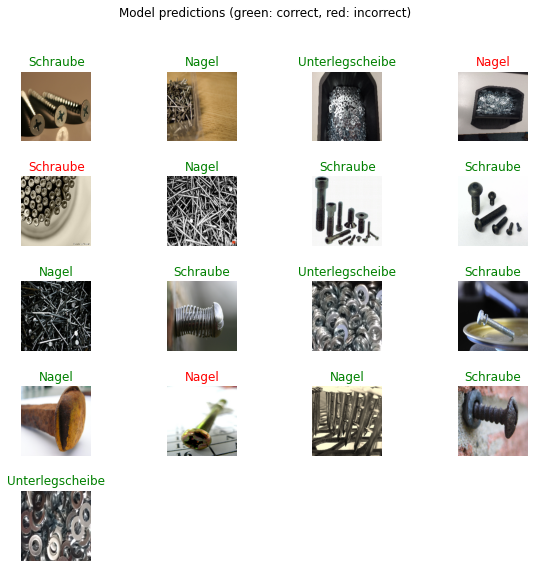

In [15]:
#Print image batch and label predictions, green means correctly predicted
predicted_ids = np.argmax(tf_model_predictions, axis=-1)
predicted_labels = dataset_labels[predicted_ids]
plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)
for n in range(17):
  plt.subplot(5,4,n+1)
  plt.imshow(val_image_batch[n])
  color = "green" if predicted_ids[n] == true_label_ids[n] else "red"
  plt.title(predicted_labels[n].title(), color=color)
  plt.axis('off')
_plot = plt.suptitle("Model predictions (green: correct, red: incorrect)")

In [16]:
import os
os.chdir('/content/drive/My Drive/textu')
!pwd

/content/drive/My Drive/textu


In [17]:
# Save the entire model as a SavedModel.

!mkdir -p saved_model
# model.save('saved_model/my_model') 
model.save('/content/drive/My Drive/textu')

# # # The '.h5' extension indicates that the model should be saved to HDF5.
model.save('my_model.h5')


# import os
# os.chdir('saved_model')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


INFO:tensorflow:Assets written to: /content/drive/My Drive/textu/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/textu/assets
